# Problem Statement

In [126]:
import numpy as np
import pywt
from scipy.special import psi, gamma # Needed for the M-step
from scipy.optimize import brentq
from scipy.integrate import quad # The key for numerical integration in the E-step



import numpy as np
import pywt
from scipy.stats import median_abs_deviation

def get_dHH1_subband(noisy_image, wavelet_name='db4'):

    coeffs = pywt.wavedec2(noisy_image, wavelet=wavelet_name, level=1)
    # Unpack the detail coefficients from the tuple
    cA, (cH1, cV1, dHH_1) = coeffs
    
    return dHH_1


def estimate_noise_std(noisy_image, wavelet_name='db4'):
    # extract dHH_1 subband 
    dHH_1 = get_dHH1_subband(noisy_image, wavelet_name=wavelet_name)
    #dHH_1 = dHH_1 / np.max(np.abs(dHH_1))  # normalize to [-1,1]
    #calculate MAD, we can take this shortcut bc awgn so we assume median is approx 0.
    mad_val = np.median(np.abs(dHH_1))
    #compute sigma_epsilon 
    sigma_epsilon = mad_val / 0.6745
    return sigma_epsilon

def estimate_alpha_c(noisy_image, sigma_eps, wavelet_name='db4'):
    #calculate sample mean
    dHH_1 = get_dHH1_subband(noisy_image, wavelet_name=wavelet_name)
    d = dHH_1.flatten()
    mean_val = np.mean(d)
    N = len(d)

    m_2 = np.mean((d-mean_val)**2)
    m_4 = np.mean((d-mean_val)**4)

    k_2 = m_2*(N/(N-1));
    k_4 = N**2*((N+1)*m_4-3*(N-1)*m_2**2)/((N-1)*(N-2)*(N-3))
    k_4 = max(k_4,1e-12)
    k2_adjust = max(k_2-sigma_eps**2,1e-12)
    print("k2_adjust:")
    print(k2_adjust)

    alpha = 3*(k2_adjust)**2/k_4
    c = k2_adjust/alpha
    alpha = max(alpha,0.1)
    c = max(c,1e-3)
    return [alpha, c]
def initial_estimate(noisy_image, wavelet_name='db4'):
  d = get_dHH1_subband(noisy_image, wavelet_name)
  sigma_eps = estimate_noise_std(noisy_image, wavelet_name)
  alpha, c = estimate_alpha_c(noisy_image, sigma_eps, wavelet_name)
  print(alpha)
  print(c)
  return [d,alpha, c, sigma_eps]

print("Meowwww")


Meowwww


In [127]:
# --- 2. E-Step Integrands (Numerator and Denominator) ---
from multiprocessing import Pool
import os 

def integrand_den(u, d, alpha, c, sigma_eps):
    """
    Integrand for the denominator of E[U|d] and E[log(U)|d] (Eq. 25 & 26).
    
    Note: The original paper uses K_nu(z) in the prior term, but the equations 
    (25 & 26) have been simplified into the shown exponential/power form 
    specific to the BKF distribution in a GSM form. We use the simplified form here.
    """
    # u is the integration variable (latent scale variable)
    # d is the current noisy coefficient
    # The term u+sigma_sq comes from the Gaussian Likelihood and the conditional variance.
    
    # Exponent term (Gaussian Likelihood and Power Term from the Gamma/Inverse Gamma part of BKF)
    exponent = (d**2 / (2 * (u + sigma_eps**2))) - (u / c)
    
    # Power term from the prior distribution
    power_term = u**(alpha - 1)
    
    # Denominator term (Likelihood and conditional variance)
    denom_term = np.sqrt(u + sigma_eps**2)
    
    # The function being integrated
    return (power_term / denom_term) * np.exp(exponent)


def integrand_num_mu(u, d, alpha, c, sigma_eps):
    exponent = (d**2 / (2 * (u + sigma_eps**2))) - (u / c)
    power_term = u**(alpha)
    denom_term = np.sqrt(u + sigma_eps**2)
    return (power_term / denom_term) * np.exp(exponent)


def integrand_num_phi(u, d, alpha, c, sigma_sq):
    #conditional for log(0) = -inf. 
    if u == 0:
        return 0.0 
    #its just the denominator multiplied bylog(u)
    return np.log(u) * integrand_den(u, d, alpha, c, sigma_sq)


def e_step_integral(d, alpha, c, sigma_epsilon):
 
    
    I_den, err_den = quad(integrand_den, 0, np.inf, args=(d, alpha, c, sigma_epsilon))
    if I_den <= 1e-15: 
        return 0.0, 0.0 # Avoid division by zero
        
    # integrate numerator for M_U(1)
    I_mu_num, err_mu_num = quad(integrand_num_mu, 0, np.inf, args=(d, alpha, c, sigma_epsilon))
    
    # integrate the numerator for phi_U(1)
    I_phi_num, err_phi_num = quad(integrand_num_phi, 0, np.inf, args=(d, alpha, c, sigma_epsilon))
    
    M_U_1 = I_mu_num / I_den 
    phi_U_1 = I_phi_num / I_den 
    
    return M_U_1, phi_U_1

# Vectorize the integral function to apply it to all coefficients in a subband
v_e_step_integral = np.vectorize(e_step_integral)


def e_step_wrapper(d_params):
    """Unpacks parameters and calls the integral function."""
    d, alpha, c, sigma_epsilon = d_params
    return e_step_integral(d, alpha, c, sigma_epsilon)

def parallel_e_step(D, alpha, c, sigma_epsilon):
    """
    Parallelizes the E-step integral calculation over the array of coefficients D.
    """
    # Create the list of parameter tuples for all coefficients
    params_list = [(d, alpha, c, sigma_epsilon) for d in D]
    
    # Use all but one core
    n_cores = os.cpu_count() - 1 
    if n_cores < 1: n_cores = 1
    
    print(f"Starting parallel integration on {len(D)} coefficients using {n_cores} cores...")
    
    with Pool(n_cores) as pool:
        results = pool.map(e_step_wrapper, params_list)
        
    # Convert list of tuples to separate NumPy arrays
    M_U_1_array = np.array([res[0] for res in results])
    phi_U_1_array = np.array([res[1] for res in results])
    
    return M_U_1_array, phi_U_1_array

print("MEEEEEEEEEEOWWW")


MEEEEEEEEEEOWWW


In [128]:
import numpy as np

def e_step_integral_vectorized_cpu(d, alpha, c, sigma_eps, u_max=100, n_points=2000, chunk_size=100):
    """
    Memory-safe E-step using trapezoidal integration over u.
    Processes coefficients in chunks to avoid huge intermediate arrays.
    
    Args:
        d : 1D array of coefficients
        alpha, c, sigma_eps : current EM parameters
        u_max : upper limit for u grid
        n_points : number of points for integration
        chunk_size : number of coefficients to process at a time
    Returns:
        M_U, phi_U : arrays of same shape as d
    """
    M_U_all = np.zeros_like(d)
    phi_U_all = np.zeros_like(d)
    
    u = np.linspace(1e-8, u_max, n_points)  # (n_points,)
    logu = np.log(np.maximum(u, 1e-15))
    
    for start in range(0, len(d), chunk_size):
        end = min(start + chunk_size, len(d))
        d_chunk = d[start:end]  # shape (chunk_size,)
        
        # Reshape for broadcasting
        d_chunk = d_chunk[None, :]  # (1, chunk_size)
        u_grid = u[:, None]         # (n_points, 1)
        
        denom = np.sqrt(u_grid + sigma_eps**2)
        exponent = (d_chunk**2 / (2*(u_grid + sigma_eps**2))) - (u_grid / c)
        
        integrand_den = (u_grid**(alpha-1) / denom) * np.exp(exponent)
        integrand_num_mu = (u_grid**alpha / denom) * np.exp(exponent)
        integrand_num_phi = logu[:, None] * integrand_den
        
        I_den = np.trapz(integrand_den, u, axis=0)
        I_mu = np.trapz(integrand_num_mu, u, axis=0)
        I_phi = np.trapz(integrand_num_phi, u, axis=0)
        
        # Avoid division by zero
        I_den_safe = np.maximum(I_den, 1e-15)
        
        M_U_all[start:end] = I_mu / I_den_safe
        phi_U_all[start:end] = I_phi / I_den_safe
        
    return M_U_all, phi_U_all


In [129]:
def e_step_change_var(alpha, c, d, sigma, a=1.0):

  def denom(u):
    return ((u**(alpha)-1) / np.sqrt(u + sigma**2) * np.exp(d**2 / (2*(u + sigma**2)) - u/c))

  def denom_sub(v):
    u = 1.0 / v
    return denom(u) / v**2
  def M_numerator(u):
    return (u**(alpha) / np.sqrt(u + sigma**2) * np.exp(d**2 / (2*(u + sigma**2)) - u/c))
  def M_numerator_sub(v):
    u = 1.0 / v
    return M_numerator(u) / v**2
  def Phi_numerator(u):
    return (np.log(u)*(u**(alpha)-1) / np.sqrt(u + sigma**2) * np.exp(d**2 / (2*(u + sigma**2)) - u/c))
  def Phi_numerator_sub(v):
    u = 1.0 / v
    return Phi_numerator(u) / v**2
  
  denom_first, _ = quad(denom, 0, a)
  denom_tail,  _ = quad(denom_sub, 0, 1/a)
  denom_val = denom_first+denom_tail+1e-12

  M_numerator_first, _ = quad(M_numerator, 0, a)
  M_numerator_tail, _ = quad(M_numerator_sub, 0, 1/a)
  M_numerator_val = M_numerator_first+M_numerator_tail

  Phi_numerator_first, _ = quad(Phi_numerator, 0, a)
  Phi_numerator_tail, _ = quad(Phi_numerator_sub, 0, 1/a)
  Phi_numerator_val = Phi_numerator_first+Phi_numerator_tail

  Mu_1 = M_numerator_val/denom_val
  Phi_1 = Phi_numerator_val/denom_val
  return Mu_1, Phi_1
def e_step_change_var_all(alpha, c, d, sigma, a=1.0):
    M_U_all = np.zeros_like(d)
    phi_U_all = np.zeros_like(d)
    for i in range(0,len(d)):
        M_U_all[i], phi_U_all[i] = e_step_change_var(alpha, c, d[i], sigma, a)
    return M_U_all, phi_U_all

In [130]:
# M-Step and the Full EM Loop

def m_step_alpha_root_func(alpha, phi_U_avg, M_U_avg):
    if alpha <= 0:
        return np.inf 
        
    # LHS of Eq. 28 
    LHS = psi(alpha) - np.log(alpha)
    # RHS of Eq. 28 (we are trying to find roots)
    RHS = phi_U_avg - np.log(M_U_avg)

    return LHS - RHS

def em_bessel_k_form_noisy(d_subband, alpha_init, c_init, sigma_epsilon, max_iter=100, tol=1e-5):
    """
    The main EM algorithm for a single wavelet subband (d).
    
    Args:
        d_subband: noisy wavelet coefficients in a single subband (2D numpy array).
        alpha_init, c_init: Initial guesses for alpha and c.
        sigma_epsilon: Estimated noise standard deviation from the MAD formula 
        
    """
    m = len(d_subband)
    alpha = alpha_init
    c = c_init
    
    # Flatten the subband data for iteration
    d_flat = d_subband.ravel() 
    
    for t in range(max_iter):
        alpha_prev = alpha
        c_prev = c
        
        # e step 
        M_U_i, phi_U_i = e_step_change_var_all( alpha, c, d_flat, sigma_epsilon,a=0.5)
        
        M_U_sum = np.sum(M_U_i)
        phi_U_sum = np.sum(phi_U_i)
        
        M_U_avg = M_U_sum / m
        phi_U_avg = phi_U_sum / m

        # m step 
        
        # Solve for alpha^(t+1) using root-finding
        a = max(alpha * 0.1, 0.01) 
        b = max(alpha *5, 5)
        
        try:
            alpha_next = brentq(
                m_step_alpha_root_func, 
                a=a, b=b, 
                args=(phi_U_avg, M_U_avg)
            )
        except Exception:
            # Fallback if root finding fails 
            alpha_next = alpha
            
        # 2. Solve for c^(t+1) (eq. 27)
        c_next = (1 / alpha_next) * M_U_avg
        
        # --- Check for Convergence ---
        alpha_diff = np.abs(alpha_next - alpha)
        c_diff = np.abs(c_next - c)
        
        alpha, c = alpha_next, c_next
        
        if alpha_diff < tol and c_diff < tol:
            # print(f"EM converged after {t+1} iterations.")
            break
            
    return alpha, c

print("Meow")

Meow


In [131]:
#closed form expressions

def A(d, c, sigma_eps):
    return np.abs(d) - np.sqrt(2/c)*(sigma_eps**2)

def lambda_func(c, alpha,sigma_eps):
    factor = np.sqrt(2) * sigma_eps
    first_term = np.sqrt(2*(1-alpha))
    second_term = sigma_eps / np.sqrt(c)
    return factor * (first_term + second_term)

def map_estimator_vec(d, A, alpha, sigma_eps, lam):
    d = np.asarray(d)
    sqrt_term = np.sqrt(np.maximum(0, A**2 + 4*sigma_eps**2*(np.abs(alpha-1))))
    result = np.sign(d)/2 * (A + sqrt_term)
    # threshold small values
    result[np.abs(d) <= lam] = 0
    return result


print("Meow")

Meow


In [132]:
#Function that adds Gaussian Noise or Poisson Noise for now (not sure if poisson works right)
def add_noise(img, SNR_dB, noise_type='gaussian'):
    signal_power = np.mean(img ** 2)
    noise_power = signal_power / (10 ** (SNR_dB / 10))
    if noise_type == 'poisson':
      lamda = np.power(10,SNR_dB/10)/np.mean(img)
      scaled = img * lamda
      noisy_counts = np.random.poisson(scaled)
      noisy = noisy_counts / lamda
    else:
        noise = np.random.normal(0, np.sqrt(noise_power), img.shape)
        noisy = img + noise
    return np.clip(noisy, 0, 1)
def estimate_SNR(img, estim_std):
     signal_power = np.mean(img ** 2)
     estim_SNR = 10 * np.log10(signal_power / (estim_std ** 2))
     return estim_SNR
print("Meow")

Meow


Meow
k2_adjust:
0.0005040727298884784
0.4568922434584404
0.0011032639251498469
k2_adjust:
1e-12
0.1
0.33333333333333337
Alpha and c estimates:
0.1
0.33333333333333337
Sigma eps:
0.35397664786916455
Meow
[[-0.28860752 -0.27584822 -0.22207125 ... -0.24759642 -0.21879468
  -0.16481213]
 [-0.26987372 -0.27181972  0.0609639  ... -0.16731952 -0.13521951
   0.04996207]
 [-0.2964757  -0.22289382  0.19602879 ... -0.23667409 -0.15225221
  -0.25480724]
 ...
 [-0.27844585 -0.20110447 -0.13786866 ... -0.26851707 -0.25247949
  -0.06879886]
 [-0.21420539  0.00075385  0.17832958 ... -0.23173046 -0.20102534
   0.30075807]
 [-0.25150937 -0.17143224 -0.1150337  ... -0.29927396 -0.18286375
  -0.02477355]]
Lambda
0.9785432272392391
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.4478377  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          

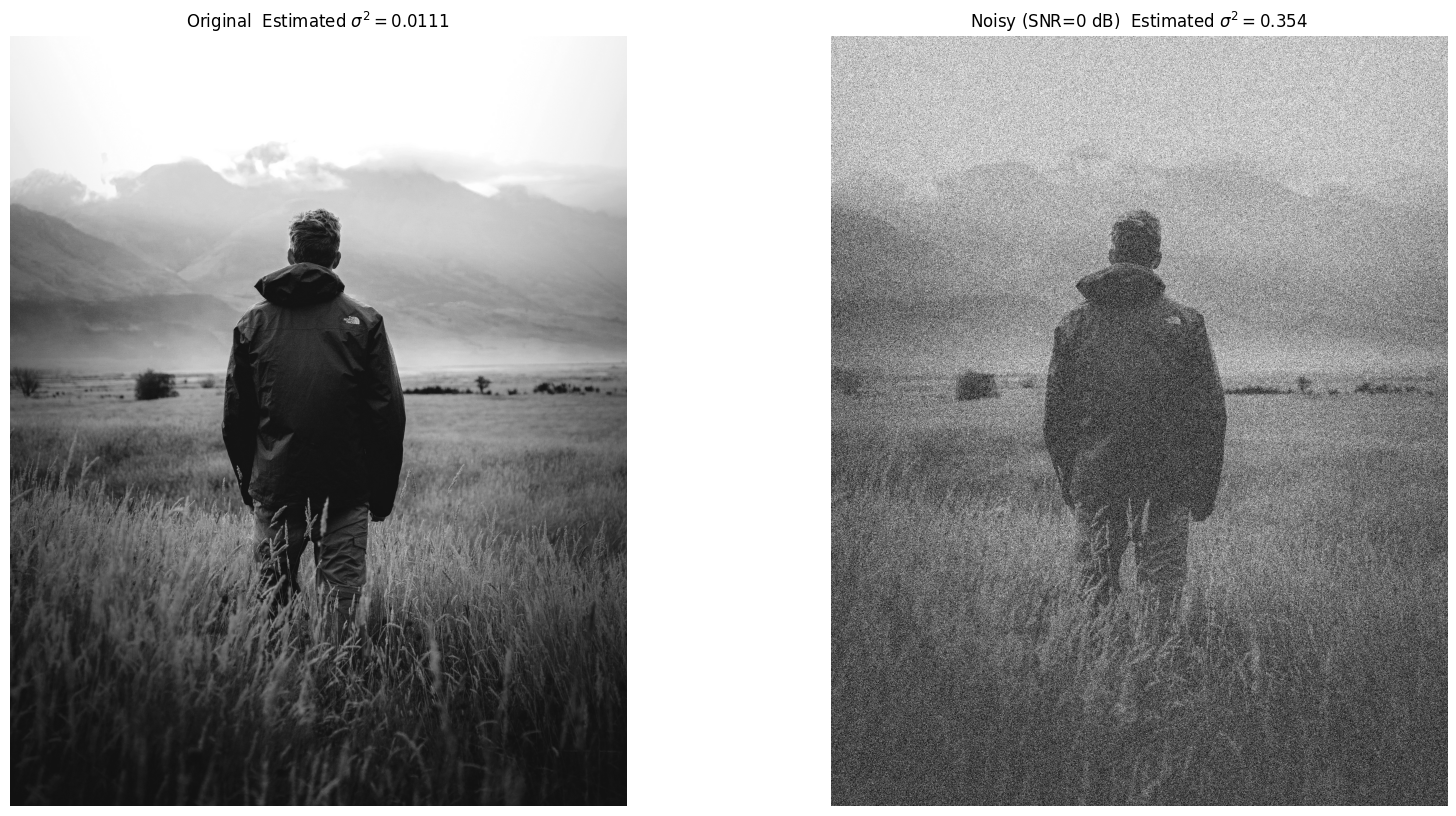

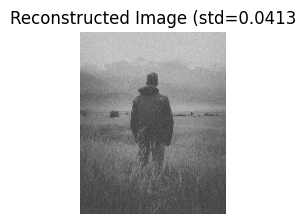

In [ ]:
# Importing an image and adding noise
from skimage import io, util, img_as_float
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
# Load image
img = img_as_float(io.imread("barbara.png"))

# Drop alpha channel if present
if img.ndim == 3 and img.shape[2] == 4:
    img = img[:, :, :3]  # keep RGB only

# Convert to grayscale
gray_img = rgb2gray(img)

print(gray_img.shape)
print("Meow")

SNR_dB = 0
noisy_img = add_noise(gray_img, SNR_dB, 'gaussian')
original_std = round(estimate_noise_std(gray_img),4)
noisy_std = round(estimate_noise_std(noisy_img),4)
[d1,alpha1,c1,sigma_eps1] = initial_estimate(gray_img)
[d2, alpha2, c2, sigma_eps2] = initial_estimate(noisy_img)
[alpha_fin, c_fin] = [alpha2, c2] #estimate_alpha_c(noisy_img, sigma_eps2)
print("Alpha and c estimates:")
print(alpha_fin)
print(c_fin)
print("Sigma eps:")
print(sigma_eps2)
print("Meow")
A_val = A(d2,c_fin,sigma_eps2)
print(A_val)
lambda_val = lambda_func(c_fin,alpha_fin,sigma_eps2)
print("Lambda")
print(lambda_val)
d_estim = map_estimator_vec(d2,A_val, alpha_fin, sigma_eps2,0.5)

coeffs = pywt.wavedec2(noisy_img, wavelet='db4', level=1)
cA, (cH1, cV1, dHH_orig) = coeffs 

d_estim_reshaped = np.reshape(d_estim, dHH_orig.shape)
print(d_estim_reshaped)
coeffs_est = [cA, (cH1, cV1, d_estim_reshaped)]
reconstructed_img = pywt.waverec2(coeffs_est, wavelet='db4')
reconstructed_img = np.clip(reconstructed_img, 0, 1)
reconstructed_std = round(estimate_noise_std(reconstructed_img),4)



plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(gray_img,cmap='gray')
plt.title(fr"Original  Estimated $\sigma^2= ${original_std}")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(noisy_img,cmap='gray')
plt.title(fr"Noisy (SNR={SNR_dB} dB)  Estimated $\sigma^2= ${noisy_std}")
plt.axis('off')
plt.show()


plt.subplot(1,3,3)
plt.imshow(reconstructed_img, cmap='gray')
plt.title(fr"Reconstructed Image (std={reconstructed_std}")
plt.axis('off')
plt.show()
